### 라이브러리 임포트

In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

### GPU 체크

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### ResNet 레이어 구성

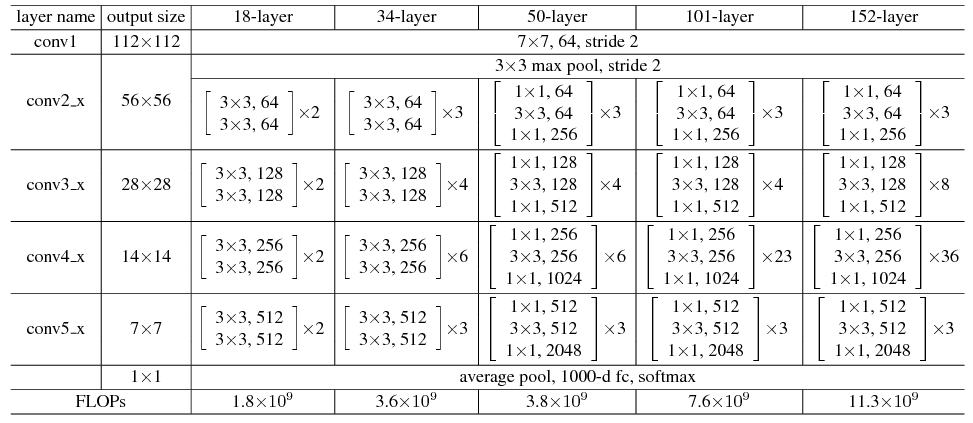

In [3]:
from IPython.display import Image
Image(filename='resnet_list.png') 

### 기본 블록 구성

In [4]:
# 기본 블록 구성하기
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1, 
               activation='relu'):
    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

### ResNet 기본 블록 구성

기본은 ResNet34 이고, is_50 이 True 인 경우에만 ResNet50

In [5]:
# ResNet 기본 블록 구성하기
def build_resnet_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=0, 
                       is_50=True):
    
    x = input_layer
    
    # ResNet-50
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    

    return x

### ResNet 모델 구성

In [6]:
# ResNet 모델 구성하기
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=True, 
                 activation='softmax',
                 name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x, 
                               num_cnn=num_cnn, 
                               channel=channel, 
                               block_num=block_num, 
                               is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

### PlainNet 기본 블록 구성하기

ResNet 에서 short-cut connection 을 없앤 것을 PlainNet 으로 하고, 비교하기 위해서 정의

In [7]:
# PlainNet 기본 블록 구성하기
def build_plain_block(input_layer, 
                      num_cnn=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
    
    x = input_layer
    
    # plain-50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
    
    # plain-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

    return x

### PlainNet 모델 구성

In [8]:
# PlainNet 모델 구성하기
def build_plainnet(input_shape=(32,32,3), 
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_50=True, 
                   activation='softmax',
                   name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 plain block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x, 
                              num_cnn=num_cnn, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

### 테스트 할 데이터셋 로드

In [19]:
# cats_vs_dogs 데이터셋 로드하기
import urllib3
urllib3.disable_warnings()

# cats_vs_dogs 데이터셋이 tensorflow API 오류로 불러오지 못하는 경우가 있을 경우
# 로드하기 전에 이것을 추가해서 새 URL을 설정할 수 있습니다.
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

(ds_train_org, ds_test_org), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True, # 데이터가 튜플로 반환, False는 dictionarty형태로 반환
    with_info=True, # 데이터의 정보를 같이 반환한다.
)

### 데이터 전처리 함수 정의

In [10]:
# 데이터 전처리하기(정규화 함수 만들기)
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    #ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 변수 선언

In [20]:
BATCH_SIZE = 32
EPOCH = 5

ds_train = apply_normalize_on_dataset(ds_train_org, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test_org, batch_size=BATCH_SIZE)

### ResNet34 학습

In [21]:
# resnet_34 학습하기
resnet_34 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=False, 
                         activation='sigmoid', 
                         name='ResNet_34')

resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_72 (Conv2D)             (None, 112, 112, 64  9472        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_72 (BatchN  (None, 112, 112, 64  256        ['conv2d_72[0][0]']              
 ormalization)                  )                                                         

 ormalization)                                                                                    
                                                                                                  
 add_35 (Add)                   (None, 28, 28, 128)  0           ['batch_normalization_81[0][0]', 
                                                                  'batch_normalization_79[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 28, 28, 128)  0           ['add_35[0][0]']                 
                                                                                                  
 conv2d_82 (Conv2D)             (None, 28, 28, 128)  147584      ['activation_74[0][0]']          
                                                                                                  
 batch_normalization_82 (BatchN  (None, 28, 28, 128)  512        ['conv2d_82[0][0]']              
 ormalizat

 ormalization)                                                                                    
                                                                                                  
 activation_83 (Activation)     (None, 14, 14, 256)  0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 conv2d_92 (Conv2D)             (None, 14, 14, 256)  590080      ['activation_83[0][0]']          
                                                                                                  
 batch_normalization_92 (BatchN  (None, 14, 14, 256)  1024       ['conv2d_92[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_40 (Add)                   (None, 14, 14, 256)  0           ['batch_normalization_92[0][0]', 
          

                                                                                                  
 batch_normalization_102 (Batch  (None, 7, 7, 512)   2048        ['conv2d_102[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_93 (Activation)     (None, 7, 7, 512)    0           ['batch_normalization_102[0][0]']
                                                                                                  
 conv2d_103 (Conv2D)            (None, 7, 7, 512)    2359808     ['activation_93[0][0]']          
                                                                                                  
 conv2d_101 (Conv2D)            (None, 7, 7, 512)    131584      ['activation_92[0][0]']          
                                                                                                  
 batch_nor

In [22]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5


/Users/ziippy/NotebookProjects/modoo-cv/venv/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-08-11 11:25:33.887703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 20/581 [>.............................] - ETA: 2:47 - loss: 3.0834 - accuracy: 0.5422

 38/581 [>.............................] - ETA: 2:40 - loss: 2.8294 - accuracy: 0.5304

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 2:18 - loss: 2.5617 - accuracy: 0.5738

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 1:17 - loss: 2.3652 - accuracy: 0.5957

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 1:13 - loss: 2.3564 - accuracy: 0.5973

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 1:09 - loss: 2.3454 - accuracy: 0.6006

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


370/581 [==================>...........] - ETA: 1:01 - loss: 2.3240 - accuracy: 0.6050

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 1:00 - loss: 2.3193 - accuracy: 0.6061

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.1757 - accuracy: 0.6309

2022-08-11 11:28:30.342344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 193s 323ms/step - loss: 2.1757 - accuracy: 0.6309 - val_loss: 1.8847 - val_accuracy: 0.5933
Epoch 2/5


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 2:46 - loss: 1.7712 - accuracy: 0.6865

 39/581 [=>............................] - ETA: 2:44 - loss: 1.7684 - accuracy: 0.6843

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


109/581 [====>.........................] - ETA: 2:22 - loss: 1.7188 - accuracy: 0.7018

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 1:17 - loss: 1.6080 - accuracy: 0.7094

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 1:13 - loss: 1.6025 - accuracy: 0.7102

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 1:09 - loss: 1.5962 - accuracy: 0.7096

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 1:01 - loss: 1.5797 - accuracy: 0.7130

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 1:00 - loss: 1.5766 - accuracy: 0.7136

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 1.4815 - accuracy: 0.7237

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.4806 - accuracy: 0.7240

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 187s 321ms/step - loss: 1.4806 - accuracy: 0.7240 - val_loss: 1.5103 - val_accuracy: 0.6277
Epoch 3/5
 29/581 [>.............................] - ETA: 2:46 - loss: 1.2292 - accuracy: 0.7381

 41/581 [=>............................] - ETA: 2:42 - loss: 1.2029 - accuracy: 0.7515

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 2:18 - loss: 1.1740 - accuracy: 0.7626

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 1:16 - loss: 1.1034 - accuracy: 0.7722

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 1:13 - loss: 1.1003 - accuracy: 0.7728

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 1:09 - loss: 1.0950 - accuracy: 0.7744

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 1:01 - loss: 1.0854 - accuracy: 0.7771

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 59s - loss: 1.0835 - accuracy: 0.7779

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.0288 - accuracy: 0.7848

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 186s 319ms/step - loss: 1.0288 - accuracy: 0.7848 - val_loss: 0.8989 - val_accuracy: 0.8062
Epoch 4/5
  1/581 [..............................] - ETA: 4:15 - loss: 0.7105 - accuracy: 0.9062

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 31/581 [>.............................] - ETA: 2:47 - loss: 0.8734 - accuracy: 0.7974

 40/581 [=>............................] - ETA: 2:44 - loss: 0.8682 - accuracy: 0.8016

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:19 - loss: 0.8464 - accuracy: 0.8128

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 1:16 - loss: 0.7955 - accuracy: 0.8257

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 1:13 - loss: 0.7931 - accuracy: 0.8267

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 1:09 - loss: 0.7913 - accuracy: 0.8263

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 1:01 - loss: 0.7905 - accuracy: 0.8259

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 59s - loss: 0.7881 - accuracy: 0.8267

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7454 - accuracy: 0.8383

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 186s 320ms/step - loss: 0.7454 - accuracy: 0.8383 - val_loss: 0.8124 - val_accuracy: 0.7929
Epoch 5/5


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 2:40 - loss: 0.6364 - accuracy: 0.8604

 43/581 [=>............................] - ETA: 2:37 - loss: 0.6319 - accuracy: 0.8590

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:21 - loss: 0.6257 - accuracy: 0.8652

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 1:16 - loss: 0.6025 - accuracy: 0.8692

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 1:12 - loss: 0.6029 - accuracy: 0.8681

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 1:08 - loss: 0.6031 - accuracy: 0.8674

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 1:00 - loss: 0.6008 - accuracy: 0.8679

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 58s - loss: 0.5995 - accuracy: 0.8679

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5801 - accuracy: 0.8711

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 186s 319ms/step - loss: 0.5801 - accuracy: 0.8711 - val_loss: 1.1873 - val_accuracy: 0.5293


### ResNet50 학습

In [23]:
# resnet_50 학습하기
resnet_50 = build_resnet(input_shape=(224, 224, 3),  
                         num_classes=1, 
                         is_50=True,
                         activation='sigmoid')

resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_108 (Conv2D)            (None, 112, 112, 64  9472        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_108 (Batch  (None, 112, 112, 64  256        ['conv2d_108[0][0]']             
 Normalization)                 )                                                         

                                                                                                  
 conv2d_118 (Conv2D)            (None, 28, 28, 256)  16640       ['activation_107[0][0]']         
                                                                                                  
 batch_normalization_118 (Batch  (None, 28, 28, 256)  1024       ['conv2d_118[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_50 (Add)                   (None, 28, 28, 256)  0           ['batch_normalization_118[0][0]',
                                                                  'activation_105[0][0]']         
                                                                                                  
 activation_108 (Activation)    (None, 28, 28, 256)  0           ['add_50[0][0]']                 
          

 add_53 (Add)                   (None, 14, 14, 512)  0           ['batch_normalization_128[0][0]',
                                                                  'activation_114[0][0]']         
                                                                                                  
 activation_117 (Activation)    (None, 14, 14, 512)  0           ['add_53[0][0]']                 
                                                                                                  
 conv2d_129 (Conv2D)            (None, 14, 14, 128)  65664       ['activation_117[0][0]']         
                                                                                                  
 batch_normalization_129 (Batch  (None, 14, 14, 128)  512        ['conv2d_129[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_139 (Batch  (None, 7, 7, 256)   1024        ['conv2d_139[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_127 (Activation)    (None, 7, 7, 256)    0           ['batch_normalization_139[0][0]']
                                                                                                  
 conv2d_140 (Conv2D)            (None, 7, 7, 256)    590080      ['activation_127[0][0]']         
                                                                                                  
 batch_normalization_140 (Batch  (None, 7, 7, 256)   1024        ['conv2d_140[0][0]']             
 Normalization)                                                                                   
          

 activation_137 (Activation)    (None, 7, 7, 256)    0           ['batch_normalization_149[0][0]']
                                                                                                  
 conv2d_150 (Conv2D)            (None, 7, 7, 1024)   263168      ['activation_137[0][0]']         
                                                                                                  
 batch_normalization_150 (Batch  (None, 7, 7, 1024)  4096        ['conv2d_150[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_60 (Add)                   (None, 7, 7, 1024)   0           ['batch_normalization_150[0][0]',
                                                                  'activation_135[0][0]']         
                                                                                                  
 activatio

                                                                                                  
 add_63 (Add)                   (None, 4, 4, 2048)   0           ['batch_normalization_160[0][0]',
                                                                  'activation_144[0][0]']         
                                                                                                  
 activation_147 (Activation)    (None, 4, 4, 2048)   0           ['add_63[0][0]']                 
                                                                                                  
 global_average_pooling2d_3 (Gl  (None, 2048)        0           ['activation_147[0][0]']         
 obalAveragePooling2D)                                                                            
                                                                                                  
 dense_3 (Dense)                (None, 1)            2049        ['global_average_pooling2d_3[0][0
          

In [24]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5


2022-08-11 12:05:28.649853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 26/581 [>.............................] - ETA: 1:59 - loss: 6.5040 - accuracy: 0.5288

 41/581 [=>............................] - ETA: 1:50 - loss: 6.3895 - accuracy: 0.5465

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 1:28 - loss: 6.1498 - accuracy: 0.5548

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 48s - loss: 5.5471 - accuracy: 0.6112

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 45s - loss: 5.5178 - accuracy: 0.6122

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 43s - loss: 5.4858 - accuracy: 0.6151

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 38s - loss: 5.4173 - accuracy: 0.6191

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 37s - loss: 5.4014 - accuracy: 0.6201

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 4.9153 - accuracy: 0.6419

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
2022-08-11 12:07:20.910287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 127s 204ms/step - loss: 4.9153 - accuracy: 0.6419 - val_loss: 3.6535 - val_accuracy: 0.6571
Epoch 2/5
 30/581 [>.............................] - ETA: 1:47 - loss: 3.5324 - accuracy: 0.7083

 42/581 [=>............................] - ETA: 1:43 - loss: 3.5078 - accuracy: 0.7039

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 1:34 - loss: 3.3932 - accuracy: 0.7061

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 49s - loss: 3.0790 - accuracy: 0.7222

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 46s - loss: 3.0606 - accuracy: 0.7239

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 44s - loss: 3.0473 - accuracy: 0.7241

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 39s - loss: 3.0119 - accuracy: 0.7256

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 38s - loss: 3.0046 - accuracy: 0.7252

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 2.7707 - accuracy: 0.7322

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.7698 - accuracy: 0.7322

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 120s 206ms/step - loss: 2.7698 - accuracy: 0.7322 - val_loss: 2.4199 - val_accuracy: 0.5824
Epoch 3/5
 28/581 [>.............................] - ETA: 1:42 - loss: 2.1415 - accuracy: 0.7266

 43/581 [=>............................] - ETA: 1:40 - loss: 2.1324 - accuracy: 0.7297

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 1:26 - loss: 2.0537 - accuracy: 0.7581

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 47s - loss: 1.9260 - accuracy: 0.7594

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 45s - loss: 1.9169 - accuracy: 0.7600

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 43s - loss: 1.9125 - accuracy: 0.7599

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 38s - loss: 1.8964 - accuracy: 0.7605

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 37s - loss: 1.8933 - accuracy: 0.7598

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.7928 - accuracy: 0.7643

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 203ms/step - loss: 1.7928 - accuracy: 0.7643 - val_loss: 2.1924 - val_accuracy: 0.5426
Epoch 4/5
  2/581 [..............................] - ETA: 1:45 - loss: 1.5474 - accuracy: 0.8125

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 1:40 - loss: 1.5018 - accuracy: 0.7885

 43/581 [=>............................] - ETA: 1:38 - loss: 1.4862 - accuracy: 0.7936

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 1:29 - loss: 1.4378 - accuracy: 0.7975

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 47s - loss: 1.3774 - accuracy: 0.7990

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 45s - loss: 1.3753 - accuracy: 0.7983

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 43s - loss: 1.3718 - accuracy: 0.7990

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 38s - loss: 1.3653 - accuracy: 0.7991

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 37s - loss: 1.3634 - accuracy: 0.7996

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.3026 - accuracy: 0.8057

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 203ms/step - loss: 1.3026 - accuracy: 0.8057 - val_loss: 1.5721 - val_accuracy: 0.6004
Epoch 5/5
 31/581 [>.............................] - ETA: 1:43 - loss: 1.1067 - accuracy: 0.8458

 44/581 [=>............................] - ETA: 1:40 - loss: 1.1090 - accuracy: 0.8409

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 1:25 - loss: 1.1164 - accuracy: 0.8246

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 47s - loss: 1.0706 - accuracy: 0.8292

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 45s - loss: 1.0677 - accuracy: 0.8292

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 43s - loss: 1.0640 - accuracy: 0.8303

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 38s - loss: 1.0582 - accuracy: 0.8314

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 36s - loss: 1.0562 - accuracy: 0.8315

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.0220 - accuracy: 0.8352

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 203ms/step - loss: 1.0220 - accuracy: 0.8352 - val_loss: 1.7824 - val_accuracy: 0.7203


### PlainNet34 학습

In [25]:
# plain_34 학습하기
plain_34 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=False, 
                          activation='sigmoid',
                          name='Plain_34')

plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_161 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_161 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_148 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_162 (Conv2D)         (None, 56, 56, 64)        369

                                                                 
 activation_164 (Activation)  (None, 14, 14, 256)      0         
                                                                 
 conv2d_178 (Conv2D)         (None, 14, 14, 256)       590080    
                                                                 
 batch_normalization_178 (Ba  (None, 14, 14, 256)      1024      
 tchNormalization)                                               
                                                                 
 activation_165 (Activation)  (None, 14, 14, 256)      0         
                                                                 
 conv2d_179 (Conv2D)         (None, 14, 14, 256)       590080    
                                                                 
 batch_normalization_179 (Ba  (None, 14, 14, 256)      1024      
 tchNormalization)                                               
                                                                 
 activatio

In [26]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5


2022-08-11 12:34:53.412386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 27/581 [>.............................] - ETA: 2:36 - loss: 2.3642 - accuracy: 0.5289

 40/581 [=>............................] - ETA: 2:32 - loss: 2.3235 - accuracy: 0.5367

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 2:10 - loss: 2.2112 - accuracy: 0.5592

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 1:13 - loss: 1.9665 - accuracy: 0.5901

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 1:09 - loss: 1.9563 - accuracy: 0.5893

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 1:06 - loss: 1.9437 - accuracy: 0.5894

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 58s - loss: 1.9181 - accuracy: 0.5858

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 56s - loss: 1.9130 - accuracy: 0.5856

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 1.7512 - accuracy: 0.5835

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.7500 - accuracy: 0.5835

2022-08-11 12:37:39.888902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 183s 304ms/step - loss: 1.7500 - accuracy: 0.5835 - val_loss: 1.3467 - val_accuracy: 0.5916
Epoch 2/5
 29/581 [>.............................] - ETA: 2:40 - loss: 1.3004 - accuracy: 0.6562

 38/581 [>.............................] - ETA: 2:38 - loss: 1.2892 - accuracy: 0.6653

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 2:13 - loss: 1.2836 - accuracy: 0.6253

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 1:13 - loss: 1.2116 - accuracy: 0.6325

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 1:11 - loss: 1.2094 - accuracy: 0.6330

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 1:07 - loss: 1.2058 - accuracy: 0.6339

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 59s - loss: 1.1967 - accuracy: 0.6348

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 57s - loss: 1.1952 - accuracy: 0.6357

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 1.1430 - accuracy: 0.6461

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.1427 - accuracy: 0.6461

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 179s 307ms/step - loss: 1.1427 - accuracy: 0.6461 - val_loss: 1.0816 - val_accuracy: 0.5370
Epoch 3/5
 28/581 [>.............................] - ETA: 2:38 - loss: 1.0251 - accuracy: 0.6328

 41/581 [=>............................] - ETA: 2:34 - loss: 1.0265 - accuracy: 0.6258

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 2:11 - loss: 1.0147 - accuracy: 0.6468

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 1:13 - loss: 0.9804 - accuracy: 0.6584

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 1:09 - loss: 0.9779 - accuracy: 0.6605

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 1:06 - loss: 0.9760 - accuracy: 0.6622

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 58s - loss: 0.9730 - accuracy: 0.6628

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 56s - loss: 0.9723 - accuracy: 0.6634

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 0.9358 - accuracy: 0.6776

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.9355 - accuracy: 0.6777

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 177s 304ms/step - loss: 0.9355 - accuracy: 0.6777 - val_loss: 1.0577 - val_accuracy: 0.5834
Epoch 4/5
 29/581 [>.............................] - ETA: 2:33 - loss: 0.8819 - accuracy: 0.6832

 43/581 [=>............................] - ETA: 2:29 - loss: 0.8785 - accuracy: 0.6853

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 2:09 - loss: 0.8497 - accuracy: 0.6991

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 1:12 - loss: 0.8420 - accuracy: 0.6946

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 1:08 - loss: 0.8432 - accuracy: 0.6940

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 1:05 - loss: 0.8439 - accuracy: 0.6930

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 58s - loss: 0.8415 - accuracy: 0.6948

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 56s - loss: 0.8429 - accuracy: 0.6939

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 0.8279 - accuracy: 0.6984

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.8279 - accuracy: 0.6983

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 177s 304ms/step - loss: 0.8279 - accuracy: 0.6983 - val_loss: 3.1817 - val_accuracy: 0.5670
Epoch 5/5
 30/581 [>.............................] - ETA: 2:34 - loss: 0.7925 - accuracy: 0.6865

 42/581 [=>............................] - ETA: 2:31 - loss: 0.7822 - accuracy: 0.6935

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 2:09 - loss: 0.7665 - accuracy: 0.7092

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 1:11 - loss: 0.7506 - accuracy: 0.7208

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 1:08 - loss: 0.7500 - accuracy: 0.7212

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 1:05 - loss: 0.7508 - accuracy: 0.7208

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 57s - loss: 0.7483 - accuracy: 0.7221

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 55s - loss: 0.7474 - accuracy: 0.7228

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.7421 - accuracy: 0.7253

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 176s 303ms/step - loss: 0.7421 - accuracy: 0.7253 - val_loss: 1.5724 - val_accuracy: 0.5122


### PlainNet50 학습

In [27]:
# plain_50 학습하기
plain_50 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=True,
                          activation='sigmoid')

plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_194 (Conv2D)         (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_194 (Ba  (None, 112, 112, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_181 (Activation)  (None, 112, 112, 64)     0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_195 (Conv2D)         (None, 56, 56, 64)        416

                                                                 
 activation_197 (Activation)  (None, 28, 28, 128)      0         
                                                                 
 conv2d_211 (Conv2D)         (None, 28, 28, 128)       147584    
                                                                 
 batch_normalization_211 (Ba  (None, 28, 28, 128)      512       
 tchNormalization)                                               
                                                                 
 activation_198 (Activation)  (None, 28, 28, 128)      0         
                                                                 
 conv2d_212 (Conv2D)         (None, 28, 28, 512)       66048     
                                                                 
 batch_normalization_212 (Ba  (None, 28, 28, 512)      2048      
 tchNormalization)                                               
                                                                 
 activatio

 tchNormalization)                                               
                                                                 
 activation_215 (Activation)  (None, 14, 14, 256)      0         
                                                                 
 conv2d_229 (Conv2D)         (None, 14, 14, 256)       590080    
                                                                 
 batch_normalization_229 (Ba  (None, 14, 14, 256)      1024      
 tchNormalization)                                               
                                                                 
 activation_216 (Activation)  (None, 14, 14, 256)      0         
                                                                 
 conv2d_230 (Conv2D)         (None, 14, 14, 1024)      263168    
                                                                 
 batch_normalization_230 (Ba  (None, 14, 14, 1024)     4096      
 tchNormalization)                                               
          

In [28]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5


2022-08-11 12:59:43.734484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 28/581 [>.............................] - ETA: 3:41 - loss: 5.3356 - accuracy: 0.4855

 37/581 [>.............................] - ETA: 3:32 - loss: 5.2969 - accuracy: 0.5084

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 2:55 - loss: 4.9926 - accuracy: 0.5230

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


319/581 [===============>..............] - ETA: 1:37 - loss: 4.2903 - accuracy: 0.5375

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 1:32 - loss: 4.2568 - accuracy: 0.5359

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 1:28 - loss: 4.2262 - accuracy: 0.5361

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 1:17 - loss: 4.1457 - accuracy: 0.5323

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 1:15 - loss: 4.1301 - accuracy: 0.5325

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 3.6873 - accuracy: 0.5242

2022-08-11 13:03:25.945586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 244s 406ms/step - loss: 3.6873 - accuracy: 0.5242 - val_loss: 2.6262 - val_accuracy: 0.5103
Epoch 2/5


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 3:31 - loss: 2.5883 - accuracy: 0.4635

 40/581 [=>............................] - ETA: 3:27 - loss: 2.5750 - accuracy: 0.4797

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 2:56 - loss: 2.5089 - accuracy: 0.4855

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 1:39 - loss: 2.3626 - accuracy: 0.5182

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 1:35 - loss: 2.3596 - accuracy: 0.5176

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 1:34 - loss: 2.3597 - accuracy: 0.5173

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


363/581 [=================>............] - ETA: 1:23 - loss: 2.3500 - accuracy: 0.5172

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 1:20 - loss: 2.3477 - accuracy: 0.5157

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 2.2577 - accuracy: 0.5270

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.2571 - accuracy: 0.5273

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 237s 408ms/step - loss: 2.2571 - accuracy: 0.5273 - val_loss: 2.2031 - val_accuracy: 0.4828
Epoch 3/5
 30/581 [>.............................] - ETA: 3:32 - loss: 1.9999 - accuracy: 0.5240

 43/581 [=>............................] - ETA: 3:23 - loss: 1.9947 - accuracy: 0.5153

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:54 - loss: 1.9529 - accuracy: 0.5465

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 1:35 - loss: 1.8811 - accuracy: 0.5422

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 1:30 - loss: 1.8766 - accuracy: 0.5413

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 1:26 - loss: 1.8727 - accuracy: 0.5431

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 1:16 - loss: 1.8616 - accuracy: 0.5452

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 1:14 - loss: 1.8597 - accuracy: 0.5454

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 1.7979 - accuracy: 0.5474

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.7975 - accuracy: 0.5475

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 236s 405ms/step - loss: 1.7975 - accuracy: 0.5475 - val_loss: 1.6144 - val_accuracy: 0.5700
Epoch 4/5
 29/581 [>.............................] - ETA: 3:31 - loss: 1.6069 - accuracy: 0.5776

 42/581 [=>............................] - ETA: 3:25 - loss: 1.5939 - accuracy: 0.5908

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 2:54 - loss: 1.6001 - accuracy: 0.5657

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 1:35 - loss: 1.5945 - accuracy: 0.5542

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 1:31 - loss: 1.5908 - accuracy: 0.5555

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 1:26 - loss: 1.5891 - accuracy: 0.5551

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 1:16 - loss: 1.5819 - accuracy: 0.5591

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 1:14 - loss: 1.5807 - accuracy: 0.5586

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.5404 - accuracy: 0.5621

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 235s 403ms/step - loss: 1.5404 - accuracy: 0.5621 - val_loss: 1.4432 - val_accuracy: 0.5241
Epoch 5/5


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 27/581 [>.............................] - ETA: 4:07 - loss: 1.4272 - accuracy: 0.5318

 43/581 [=>............................] - ETA: 3:43 - loss: 1.4192 - accuracy: 0.5250

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 2:58 - loss: 1.4065 - accuracy: 0.5475

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 1:36 - loss: 1.3731 - accuracy: 0.5686

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 1:31 - loss: 1.3728 - accuracy: 0.5677

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 1:27 - loss: 1.3720 - accuracy: 0.5684

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 1:17 - loss: 1.3688 - accuracy: 0.5705

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 1:15 - loss: 1.3675 - accuracy: 0.5716

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 1.3482 - accuracy: 0.5735

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 234s 403ms/step - loss: 1.3482 - accuracy: 0.5735 - val_loss: 1.3240 - val_accuracy: 0.4996


### 시각화하여 결과 비교

In [30]:
%matplotlib inline

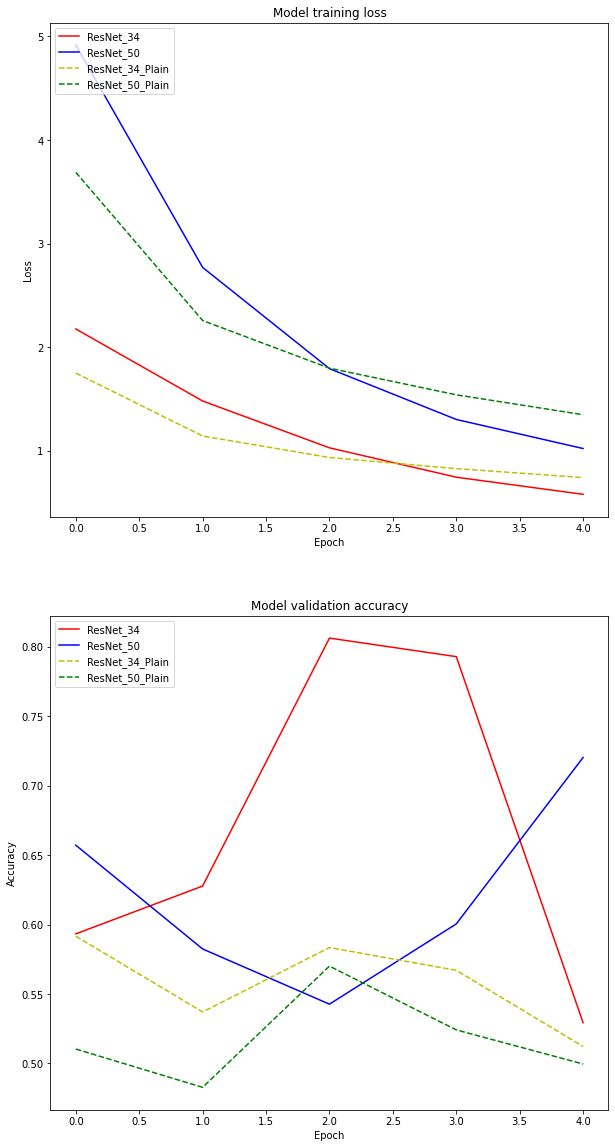

In [31]:
# 시각화하여 결과 비교하기
plt.figure(figsize=(10, 20))
plt.subplot(2, 1, 1)

plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_resnet_50.history['loss'], 'b')
plt.plot(history_plain_34.history['loss'], 'y', linestyle='dashed')
plt.plot(history_plain_50.history['loss'], 'g', linestyle='dashed')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','ResNet_34_Plain','ResNet_50_Plain'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.plot(history_plain_34.history['val_accuracy'], 'y', linestyle='dashed')
plt.plot(history_plain_50.history['val_accuracy'], 'g', linestyle='dashed')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','ResNet_34_Plain','ResNet_50_Plain'], loc='upper left')
plt.show()